In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from pythainlp.tokenize import word_tokenize
import emoji
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from visualize import top_feats_all, plot_top_feats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('sentiment_analysis.csv')
df = df.drop(df.columns[0], axis=1)
df = df.loc[df['target']=='neg']
df

,comments,target
7,ยังรู้สึกไม่ตรงตามความต้องการ เนื้อหาไม่ละเอียด,neg
10,อาจารย์สอนเข้าใจดี ขาดเทคนิดในการสอนให้น่าติดต...,neg
16,ได้ภาพกว้างดีค่ะ แต่อยากทำ assignment เยอะหน่อ...,neg
20,อ่านมาเล่า,neg
22,less explanation in github which quite hard to...,neg
...,...,...
837,คลิปสั้นกระชับก็จริงนะคะ แต่เสียตังค์มาแล้วก็อ...,neg
838,เตรียมขาหมูก่อนทำต้ม​ไม่เป็น​ ในคลิปไม่มีสอนม...,neg
839,สอนไม่ละเอียดเท่าที่ควร บางอย่างทำเสร็จใส่ถ้วยไว้,neg
846,เรียนแล้วยังไม่ค่อยเข้าใจเท่าไหร่ค่ะ น่าจะเหมา...,neg


In [3]:
#from pythainlp.corpus import thai_stopwords
#thaistopwords = list(thai_stopwords())
stopwords = ['ที่','และ','เป็น','มี','ให้','ครับ','ค่ะ','ใน','ได้','การ','มา','ๆ','นี้','ไป','จะ','เลย']

In [4]:
from pythainlp.util import normalize

def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    res = text.lower().strip() 
    res = replace_url(res)
    res = [word for word in word_tokenize(res) if word not in stopwords and not re.search(pattern=r"\s+", string=word)]
    res = ungroup_emoji(res)
    return res

In [5]:
df['processed'] = df.comments.map(lambda x: '|'.join(process_text(x)))

In [6]:
#lr = LogisticRegression()

tfidf = TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2), min_df=20,max_df=0.5, sublinear_tf=True)
tfidf_fit = tfidf.fit(df['comments'])
text_df = tfidf_fit.transform(df['comments'])

/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [7]:
text = text_df.toarray()
final_df = pd.DataFrame(data = text, columns=tfidf.get_feature_names())

/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9), KMeans(n_clusters=10), KMeans(n_clusters=11)]
[29.618225529497288, 16.784069287811484, 8.704073655121682, 4.4731154661738195, 3.3609022360874095, 2.307519601112179, 1.5868440523114953, 0.9286929007390738, 0.6859828332682754, 0.5625213175756881, 0.47462410492439233]


<function matplotlib.pyplot.show(close=None, block=None)>

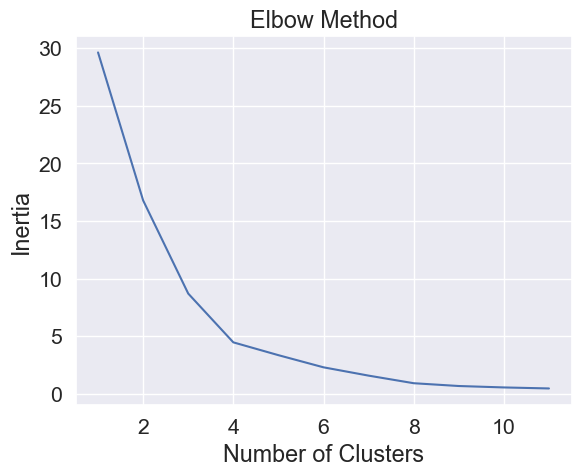

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(final_df)

number_clusters = range(1,12)

kmeans = []
for i in number_clusters:
    kmeans.append(KMeans(n_clusters=i, max_iter = 300))
print(kmeans)
inertia =[]
for i in number_clusters:
    model = KMeans(n_clusters=i,max_iter=300,n_init=10,random_state=0)
    model.fit(Y_sklearn)
    inertia.append(model.inertia_)
print(inertia)

plt.plot(number_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show

In [21]:
from imblearn.pipeline import make_pipeline
k = 3
km = KMeans(n_clusters=k, init='k-means++', max_iter=100,random_state=0)
neg_kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100,random_state=0).fit(final_df)
pipeline = make_pipeline(tfidf,km)

In [22]:
neg_k = pipeline.fit(df.comments)

In [23]:
centroids = neg_kmeans.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = tfidf.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: อยาก แต่ ว่า สอน ไม่
Cluster 1: แต่ สอน ว่า ไม่ อยาก
Cluster 2: ไม่ ว่า สอน แต่ อยาก


/Users/suthatipchaithap/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
word_cluster_pred=neg_k.predict(df.comments)

In [13]:
df['Kmean Clus Label'] = neg_kmeans.labels_

In [14]:
df['Kmean Clus Label'].value_counts()

1    47
2    31
0    22
Name: Kmean Clus Label, dtype: int64

In [17]:
for i in df['comments'].loc[df['Kmean Clus Label']==1]:
    print(i)

อ่านมาเล่า
less explanation in github which quite hard to follow for the one who doesn't familiar with jupyter, tensorflow, python
รู้ว่าData Scientist คืออะไร ใช้ทำอะไรในองค์กร
ลิงค์ไม่ได้อัพเดทมากนัก ต้องไปควานหาเอาในอากู๋เองพอสมควร แต่นอกนั้นก็สอนโอเคเลยนะ
สอนการใช้งานพื้นฐานได้ดี
คิดว่า ยากเกินไปค่ะ แต่พยายามจะเข้าใจในบทเรียนนะคะ
ยากจัง ต้องดูซ้ำๆหลายๆรอบ
สอนให้รู้จักการใช้งาน tools ต่างๆได้ดีและเข้าใจง่าย จะดียิ่งขึ้นถ้าหากนำเสนอให้ tools ต่างๆที่สอน สามารถนำไปใช้หา insights ที่ซ่อนอยู่ของข้อมูลตัวอย่างได้จริง
คือเนื้อหาดีมาก แต่ฝึกทำตามลำบาก ไม่คุ้นเคยกับโปรแกรม เรียนรู้ช้า แต่ยอมรับว่าเนื้อหามีประโยชน์สำหรับผู้ที่ฝึกใช้ได้บ่อย ๆ
เป็นโปรแกรมที่มีรายละเอียดมาก และผู้สอนสอนเร็วในระยะเวลาจำกัด เนื้อหาจึงรวบรัด นำไปใช้ได้ในระดับเบื้องต้น
เนื้อหาน้อยเกินไป สำหรับที่จะนำไปใช้งานได้จริง สำหรับคนที่เริ่มต้น
คอร์สเขียนเรียน4ถึง6ชั่วโมง เวลาเรียนจริงประมาณ2ชั่วโมง
โดยส่วนตัวมองว่า ทักษะการนำเสนอเเละสื่อสารของผูัสอนยังคงขาดรายละเอียดที่จะสามารถดึงดูดความสนใจของผู้เรียนให้สนใจการเรียนในคอร์ส

In [ ]:
current_labels = [0, 1, 2]
desired_labels = ['แต่', 'อยาก', 'ไม่']
# create a dictionary for your corresponding values
map_dict = dict(zip(current_labels, desired_labels))

# map the desired values back to the dataframe
# note this will replace the original values
df['Kmean Clus Label'] = df['Kmean Clus Label'].map(map_dict)


In [24]:
label = list(df['Kmean Clus Label'].unique())
label

[2, 0, 1]

2


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_13811/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


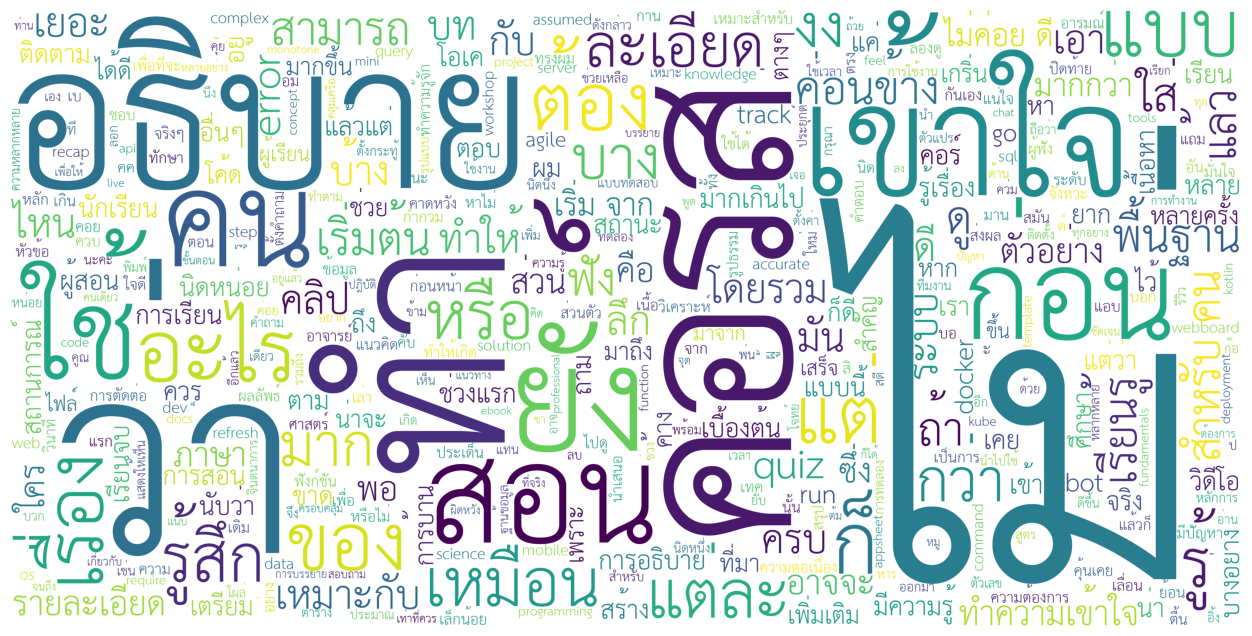

0


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_13811/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


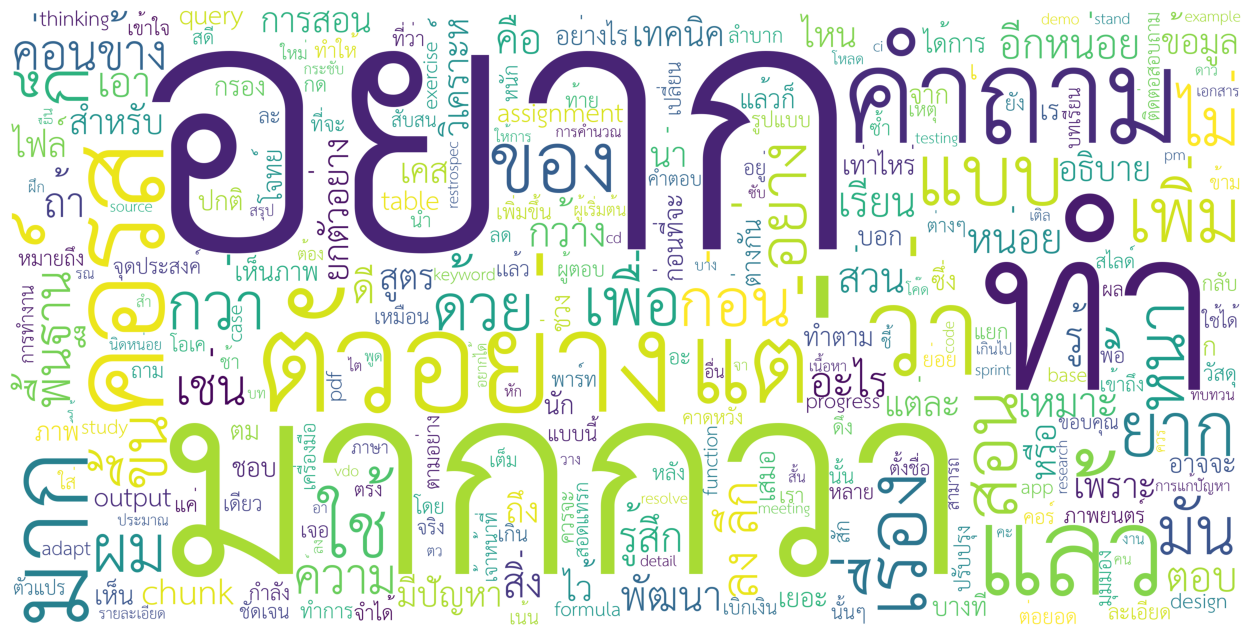

1


/var/folders/by/0rz3gnw148l6ch25mwf10xjc0000gn/T/ipykernel_13811/214124685.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  word_all = " ".join(text for text in data['processed'].str.replace('|',' '))


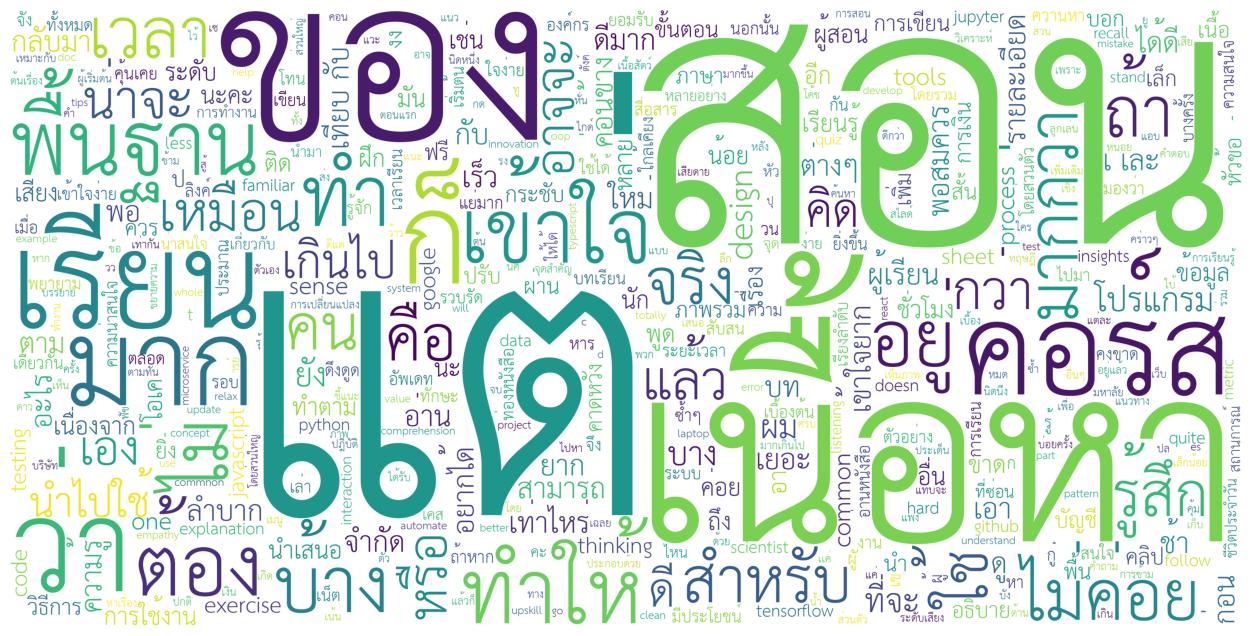

In [25]:
for i in label:
    print(i)
    data = df[df['Kmean Clus Label'] == i]
    word_all = " ".join(text for text in data['processed'].str.replace('|',' '))
    reg = r"[ก-๙a-zA-Z']+"
    fp = 'thsarabunnew-webfont.ttf'
    wordcloud = WordCloud(background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(word_all)
    plt.figure(figsize = (16,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [26]:
sample = ['สอนดีมากๆค่ะ','อยากให้สอนได้ละเอียดมากกว่านี้','สอนค่อนข้างดี แต่อยากได้ตัวอย่าง','ไม่สนุกเลย','อยากให้เพิ่มเนื้อหา','สอนละเอียดมากครับ']
neg_k.predict(sample)

array([0, 2, 0, 1, 2, 0], dtype=int32)

In [27]:
import pickle
pickle.dump(neg_k, open('neg_clustering.pkl', 'wb'))